## Setup code
Run this to set up all the pre-written functions that make everything work.

### Imports
Run to import required modules

In [ ]:
import datetime
import time
import sys
import os
import getopt

import json
import requests
import re
import urllib.parse
import ast

import math
import pandas as pd
import collections
import itertools
from scipy import stats

import matplotlib.pyplot as plt
from IPython.display import HTML, display

import pickle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loader class
This loader class parses a `watch-history.json` file from Google Takeout to get weather and song history data. Generates supplemental matrices such as unique artists and unique songs. Functionality can be adjusted with parameters when constructing class.

Contains a LOT of bad, sloppy, lazy code.

In [ ]:
class Loader():
    # initializes parameters
    def __init__(self, duration=True, more_details=True, use_songs=True, analyze_year="", apikey="", filepath="", ignores={"Title": [], "Artist": [], "URL": []}):
        self.duration, self.more_details, self.use_songs, self.analyze_year, self.apikey, self.filepath, self.ignores = (duration, more_details, use_songs, analyze_year, apikey, filepath, ignores)
        self.file = self.open_file(self.filepath, ".json")
        self.out = display(self.progress(0, 100), display_id=True)

    # utility methods
    # filters irrelevant watch history entries
    def should_not_ignore(self, title, year, header):
        if header == "YouTube Music" and title[:7] == "Watched" and year[:4] in self.analyze_year:
            return 1
        if header == "YouTube" and title == "Visited YouTube Music" and year[:4] in self.analyze_year:
            return 2
        return 0

    # loads file in an unnecessarily complex way
    def open_file(self, filepath, filetype):
        if (filepath.endswith(filetype)):
            try:
                file = open(filepath, "r", encoding="utf8")
                return file
            except:
                print("Could not open your report file")
                sys.exit()
        else:
            print("Incorrect filetype.")
            sys.exit()


    # processes bulk lists
    def parse_json(self):
        # load weather and song history data into matrices
        self.history = {"Title": [], "Artist": [], "Year": [], "URL": [], "Duration": [], "WeatherData": []}
        self.weather_history = {"Year": [], "Temperature": [], "Weather": []}
        json_object = json.load(self.file)
        for obj in json_object:
            if self.should_not_ignore(obj['title'], obj['time'], obj['header']) == 1:
                if 'subtitles' in obj:
                    self.history["Title"].append(obj['title'][8:])
                    self.history["Artist"].append(obj['subtitles'][0]['name'].replace('- Topic ', '').replace('- Topic', ''))
                    self.history["Year"].append(obj['time'])
                    self.history["URL"].append(obj['titleUrl'][32:])
                    self.history["Duration"].append(0)
                    self.history["WeatherData"].append({})
            elif self.should_not_ignore(obj['title'], obj['time'], obj['header']) == 2:
                if 'subtitles' in obj:
                    self.weather_history["Year"].append(obj['time'])
                    temperature = "INVALID"
                    weather = "INVALID"
                    for i in obj['subtitles']:
                        if "Temperature:" in i['name']:
                            temperature = i['name'][13:]
                        if "Weather:" in i['name']:
                            weather = i['name'][9:]
                    self.weather_history["Temperature"].append(temperature)
                    self.weather_history["Weather"].append(weather)

        # preprocessing
        for i in range(len(self.history["Title"])):
            if i >= len(self.history["Title"]):
                break
            if self.history["Title"][i] in self.ignores["Title"] or self.history["Artist"][i] in self.ignores["Artist"] or self.history["URL"][i] in self.ignores["URL"]:
                del self.history["Title"][i]
                del self.history["Artist"][i]
                del self.history["Year"][i]
                del self.history["URL"][i]
                del self.history["Duration"][i]
                del self.history["WeatherData"][i]
                i-= 1

        # bind most recent weather to song
        self.get_weather()

        # calclate occurrences per song
        occurrences = collections.Counter(self.history['URL'])
        self.history['Occurrences'] = []
        for i in self.history['URL']:
            self.history['Occurrences'].append(occurrences[i])

        # generate artists matrix
        occurrences = collections.Counter(self.history['Artist'])
        duration = [0]*len(occurrences.keys())
        self.artists = {"Artist": occurrences.keys(), "Occurrences": occurrences.values(), "Duration": duration}

    # generates dataframes and csv files
    def gen_csvs(self):
        self.historyDF = pd.DataFrame(self.history)
        self.historyDF.to_csv("report-history.csv")

        self.artistsDF = pd.DataFrame(self.artists)
        self.artistsDF.to_csv("report-artists.csv")

        self.songsDF = pd.DataFrame(self.history)
        self.total_songs = len(self.songsDF)
        self.songsDF.drop_duplicates(subset=['URL'], inplace=True)
        self.unique_songs = len(self.songsDF)
        self.songsDF = self.songsDF.reset_index(drop=True)
        self.songsDF.to_csv("report-songs.csv")

        self.weatherDF = pd.DataFrame(self.weather_history)
        self.weatherDF.to_csv("report-weather.csv")

    # API management functions
    # parse duration into seconds in an unnecessarily bad and clunky way
    def parse_duration(self, duration):
        timestr = duration
        time = re.findall(r'\d+', timestr)
        length = len(time)
        if length > 4:
            return 0
        if length == 4:
            return ((int(time[0])*24*60*60)+(int(time[1])*60*60)+int(time[2]*60)+(int(time[3])))
        elif length == 3:
            return ((int(time[0])*60*60)+(int(time[1])*60)+(int(time[2])))
        elif length == 2:
            return ((int(time[0])*60)+(int(time[1])))
        elif length == 1:
            return (int(time[0]))
        else:
            return 0

    # request duration of song by URL from YouTube API
    def call_api(self, idlist):
        parameters = {"part": "contentDetails,snippet",
                      "id": ','.join(idlist), "key": self.apikey}
        response = requests.get(
            "https://www.googleapis.com/youtube/v3/videos", params=parameters)

        if (response.status_code == 200):
            json_parsed = response.json()
            for item in json_parsed['items']:
                duration = self.parse_duration(item['contentDetails']['duration'])
                url = item['id']
                if duration < 10:
                    duration = duration * 60

                # update by url
                for (j, i) in enumerate(self.history["URL"]):
                    if i == url:
                        if duration >= 10:
                            self.history["Duration"][j] = duration

    # generate progress bar for Colab visualization
    # TODO should probably add this to genres
    def progress(self, value, max=100):
        return HTML("""
            <progress
                value='{value}'
                max='{max}',
                style='width: 100%'
            >
                {value}
            </progress>
        """.format(value=value, max=max))

    # terribly clunky method which bulk requests YouTube API for all song durations, creates supplemental matrices
    def get_duration(self):
        # Count duration
        idlist = []
        calls = 0
        unique_song_urls = set(self.history['URL'])
        len_usurl = len(unique_song_urls)
        print("Getting durations. This may take a while. Awaiting", len_usurl, "requests.")
        for url in unique_song_urls:
            idlist.append(url)
            if len(idlist) == 50:
                self.out.update(self.progress(((1+50*calls)*100)/len_usurl, 100))
                self.call_api(idlist)
                calls += 1
                idlist = []
        self.out.update(self.progress(100, 100))
        self.call_api(idlist)

        artist_durations = {}
        for i in range(len(self.history["Artist"])):
            duration = self.history["Duration"][i]
            artist = self.history["Artist"][i]
            try:
                artist_durations[artist] += duration
            except:
                artist_durations[artist] = duration

        occurrences = collections.Counter(self.history["Artist"])
        artists_dict = collections.defaultdict(list)
        for i in (artist_durations, occurrences):
            for key, val in i.items():
                artists_dict[key].append(val)

        durations = []
        occurrences = []
        for i, j in artists_dict.values():
            durations.append(i)
            occurrences.append(j)

        self.artists = {"Artist": artists_dict.keys(), "Occurrences": occurrences, "Duration": durations}

        self.gen_csvs()

    # binds most recent weather to every song in history
    def get_weather(self):
        curr_time_idx = 0
        for c, i in enumerate(self.history['Year']):
            weather_time = datetime.datetime.strptime(self.weather_history['Year'][curr_time_idx][:self.weather_history['Year'][curr_time_idx].index(":")+2], "%Y-%m-%dT%H:%M")
            if curr_time_idx+1 < len(self.weather_history['Year']):
                next_weather_time = datetime.datetime.strptime(self.weather_history['Year'][curr_time_idx+1][:self.weather_history['Year'][curr_time_idx+1].index(":")+2], "%Y-%m-%dT%H:%M")
            song_time = datetime.datetime.strptime(i[:i.index(":")+2], "%Y-%m-%dT%H:%M")
            diff1 = abs(song_time - weather_time)
            diff2 = abs(song_time - next_weather_time)
            if diff2 <= diff1:
                curr_time_idx += 1
            if curr_time_idx+1 == len(self.weather_history['Year']):
                curr_time_idx -= 1
            self.history['WeatherData'][c]['Temperature'] = self.weather_history['Temperature'][curr_time_idx]
            self.history['WeatherData'][c]['Weather'] = self.weather_history['Weather'][curr_time_idx]

    # generates and returns matrices (no load)
    def outs(self):
        print("We are now processing your file")
        self.parse_json()

        if self.duration:
            self.get_duration()
        else:
            self.gen_csvs() # generates dataframes and CSVs

        return self.historyDF, self.artistsDF, self.songsDF, self.weatherDF

    # loads matrices from filesystem and returns (load)
    def load(self, loadfp):
        print("Loading your preprocessed history files")
        historyDF = pd.read_csv(self.open_file(os.path.join(loadfp, "report-history.csv"), ".csv"))
        artistsDF = pd.read_csv(self.open_file(os.path.join(loadfp, "report-artists.csv"), ".csv"))
        songsDF = pd.read_csv(self.open_file(os.path.join(loadfp, "report-songs.csv"), ".csv"))
        weatherDF = pd.read_csv(self.open_file(os.path.join(loadfp, "report-weather.csv"), ".csv"))

        return (historyDF, artistsDF, songsDF, weatherDF)

### Analyzer class
Analyzer class processes generated dataframes returned by the Loader class.
- `tops()` returns a tuple of two lists: top 10 songs (by occurrences) and top 10 artists (by total time listened)
- `meta()` returns general information about watch history as a dictionary
- `genre_binds()` TODO
- `artist_genres()` uses MusicBrainz API, combined with optional user input (customize with flags) to generate genres for artists. Genres can be simplified to a few basic ones using flags.
- `weather_distribution_totals()` returns the total counts of all songs for each temperature-weather combination
- `weather_chi_squared()` returns components of a chi-squared test for homogeneity as a dictionary

In [ ]:
class Analyzer():
    # stores passed-throuhg dataframes
    def __init__(self, historyDF, artistsDF, songsDF, weatherDF):
        self.history = historyDF
        self.artists = artistsDF
        self.songs = songsDF
        self.weatherDF = weatherDF

    # top 10 songs and artists
    def tops(self):
        songs_top = self.songs.nlargest(10, ['Occurrences'])
        artists_top = self.artists.nlargest(10, ['Duration'])

        return artists_top, songs_top

    # return basic important data ('metadata' is used erroneously here but I am lazy)
    def meta(self):
        meta = {}
        meta["Total Seconds"] = sum(self.history["Duration"])
        meta["Total Songs"] = len(self.history["Title"])
        meta["Unique Songs"] = len(self.songs["Title"])
        meta["Unique Artists"] = len(self.artists["Artist"])
        return meta

    # requests MusicBrainz API or manual user input to store the genre of all artists
    def artist_genres(self, load=True, write=False, manual_fill=False, all_manual=False, debug=False, uniques=True, condense=True, lim=-1):
        # warning: do not use debug flag in conjunction with other flags other than write, lim
        # use to just load in a file instead of re-pinging API

        # load in genre condensation files (mandatory, usage is optional)
        # WARNING: THIS MAY NOT ACCOUNT FOR ALL GENRE CONVERSIONS AND THERE IS CURRENTLY NO BUILT-IN METHOD TO ADD NEW ONES
        with open('genre_binds.txt', 'r') as convert_file:
            genre_binds = json.load(convert_file)

        if load:
            with open('artist_tags.txt', 'r') as convert_file:
                artist_tags = json.load(convert_file)
            if manual_fill:
                c = 0
                for key, val in artist_tags.items():
                    if len(val) < 1:
                        artist_tags[key] = [x.strip() for x in input("Enter (comma-separated if multiple) tags for artist " + key + "\n").split(',')]
                    c+= 1
                    if c%50 == 0:
                        print("Processed", c, "artists")
            if condense:
                for key, val in artist_tags.items():
                    new_list = []
                    for i in val:
                        if i not in genre_binds.keys():
                            new_list.append(input('\nEnter a valid genre to replace ' + i + ' for artist ' + key))
                        else:
                            new_list.append(genre_binds[i])
                    if uniques:
                        new_list = list(set(new_list))
                    artist_tags[key] = new_list

            if write:
                with open('artist_tags.txt', 'w') as convert_file:
                    convert_file.write(json.dumps(artist_tags))
            return artist_tags

        # load in accepted genres from file (mandatory)
        allowed_vals_f = open('genres.txt', 'r')
        allowed_vals = []
        for i in allowed_vals_f:
            allowed_vals.append(i.replace("\n", ""))

        # requests MusicBrainz database
        artist_tags = {} # list of present allowed tags
        artist_tags_debug = {} # list of all present tags (return with the debug option)

        # use the lim flag to only get lim amount of artists for debugging, etc.
        if lim == -1:
            lim = len(self.artists['Artist'])

        print(lim, "Artists to process")
        for c, i in enumerate(self.artists['Artist'][0:lim]):
            # use the all_manual option to manually enter data for all artists (no crowdsourcing)
            artist_tags[i] = []
            artist_tags_debug[i] = []
            if all_manual:
                artist_tags[i] = [x.strip() for x in input("Enter (comma-separated if multiple) tags for artist " + i + "\n").split(',')]
                if c % 50 == 0:
                    print("Processed", c, "artists")
            else:
                response = requests.get("https://musicbrainz.org/ws/2/artist/?fmt=json&query=name:" + urllib.parse.quote(i.strip()))
                if c % 20 == 0:
                    print("Processed", c, "artists")
                try:
                    tags = response.json()['artists'][0]['tags']
                    for ii in tags:
                        artist_tags_debug[i].append(ii['name']) # dumps all tags (allowed or not) for debugging
                        if ii['name'] in allowed_vals:
                            if condense:
                                try:
                                    artist_tags[i].append(genre_binds[ii['name']])
                                except KeyError:
                                    print("Enter a valid key for artist", i)
                                    artist_tags[i].append(genre_binds[input()])
                            else:
                                artist_tags[i].append(ii['name'])
                    # use the uniques flag to prevent duplicate tags for artists (recommended)
                    if uniques:
                        artist_tags[i] = list(set(artist_tags[i]))
                except:
                    # use the manual_fill option to manually enter data for artists with no tags (on by default)
                    if manual_fill:
                        artist_tags[i] = [x.strip() for x in input("Enter (comma-separated if multiple) tags for artist " + i + "\n").split(',')]

        # use the write option to store artist tags for easy loading
        if write:
            with open('artist_tags.txt', 'w') as convert_file:
                if debug:
                    convert_file.write(json.dumps(artist_tags_debug))
                else:
                    convert_file.write(json.dumps(artist_tags))

        if debug:
            return artist_tags_debug
        return artist_tags

    # calcualtes total songs under each weather pattern
    # TODO replace code with weather_distributions_genres() method call
    def weather_distributions_totals(self):
        weather_dist = {}
        for c, i in enumerate(self.history['WeatherData']):
            j = json.loads(str(i).replace('\'', '\"'))
            t, w = j['Temperature'], j['Weather']
            if w == 'Thunderstorm':
                w = "Rain"
            if t + ";" + w in weather_dist.keys():
                weather_dist[t + ";" + w] += 1
            else:
                weather_dist[t + ";" + w] = 1

        return weather_dist

    # calculates distributions of genres under a weather pattern: use flag to determine temperature, weather, or both
    def weather_distributions_genres(self, artist_tags, dist_type="Both"):
        weather_dist = {}
        for c, (weather, artist) in enumerate(zip(self.history['WeatherData'], self.history['Artist'])):
            j = json.loads(str(weather).replace('\'', '\"'))
            t, w = j['Temperature'], j['Weather']
            if w == 'Thunderstorm':
                w = "Rain"
            if dist_type.lower()=="both":
                ind = t + ";" + w
            elif dist_type.lower()=="weather":
                ind = w
            elif dist_type.lower()=="temperature":
                ind = t
            else:
                print("INVALID DISTRIBUTION TYPE")
                return -1
            if ind in weather_dist.keys():
                for i in artist_tags[artist]:
                    if i in weather_dist[ind].keys():
                        weather_dist[ind][i] += 1
                    else:
                        weather_dist[ind][i] = 1
            else:
                weather_dist[ind] = {}
                for i in artist_tags[artist]:
                    weather_dist[ind][i] = 1

        return weather_dist

    # returns components of a chi_squared value for an input weather distribution
    def weather_chi_squared(self, weather_dist):
        rtrn = {}

        # handles missing/invalid data
        invalid_keys = []
        for key in weather_dist.keys():
            if "INVALID" in key:
                invalid_keys.append(key)
        for i in invalid_keys:
            del weather_dist[i]

        rtrn['original'] = weather_dist

        # generate possible weather keys
        pattern_keys = set([item for sublist in weather_dist.values() for item in sublist])

        # generate row and column totals
        weather_dist_totals = {}
        for key, val in weather_dist.items():
            weather_dist_totals[key] = sum(collections.Counter(val).values())
        genre_totals = {}
        for key, val in weather_dist.items():
            for genre, count in val.items():
                if genre in genre_totals.keys():
                    genre_totals[genre] += count
                else:
                    genre_totals[genre] = count
        grand_total = sum(genre_totals.values())
        rtrn['row_total'] = weather_dist_totals
        rtrn['col_total'] = genre_totals
        rtrn['total'] = grand_total

        # calculate expected values matrix
        expected_values = {}
        expected_value_check = False
        for key, val in weather_dist.items():
            expected = {}
            for genre, count in val.items():
                expected[genre] = (genre_totals[genre] * weather_dist_totals[key]) / grand_total
                if expected[genre] < 5:
                    print("EXPECTED VALUE ERROR: CONDITIONS INVALID for " + key + ", " + genre + ", expected value " + str(expected[genre]) + ", observed count " + str(count))
                    expected_value_check = True
            expected_values[key] = expected

        rtrn['expected'] = expected_values
        if expected_value_check:
            return False

        # calculate component values matrix
        component_matrix = {}
        for key, val in weather_dist.items():
            comp = {}
            for genre, count in val.items():
                expected = expected_values[key][genre]
                observed = count
                comp[genre] = (observed - expected) ** 2 / expected
            component_matrix[key] = comp

        rtrn['component'] = component_matrix

        # calculate chi-squared total
        chi_squared = 0
        for key, val in component_matrix.items():
            for genre, component in val.items():
                chi_squared += component

        rtrn['chi_squared'] = chi_squared
        #len(list(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type="temperature").items())[0][1])

        rtrn['p_val'] = stats.distributions.chi2.sf(chi_squared, (len(list(weather_dist.items()))-1) * (len(list(weather_dist.items())[0][1])-1))

        return rtrn

    def two_samp_z_test(self, x1, n1, x2, n2, diff=0, alt='larger', prop_var=False):
        rtrn = {}
        phat_c = (x1+x2)/(n1+n2)
        rtrn['p1'] = x1/n1
        rtrn['p2'] = x2/n2
        rtrn['phat_c'] = phat_c
        if phat_c * n1 < 10 or (1-phat_c) * n1 < 10 or phat_c * n2 < 10 or (1-phat_c) * n2 < 10:
            print("EXPECTED VALUE ERROR")
            return -1
        stdev = math.sqrt( (phat_c * (1-phat_c) / n1) + (phat_c * (1-phat_c) / n2))
        rtrn['SE'] = stdev
        z = ( (x1/n1) - (x2/n2) ) / stdev
        rtrn['z'] = z
        p_val = stats.norm.sf(abs(z))
        rtrn['p_val'] = p_val

        return rtrn

## Execution code
Run this code to actually generate results based on our dataset loader and analyzer classes.

Run this only once to properly adjust the working directory.

In [ ]:
os.chdir("drive/My Drive/Colab Notebooks/apstats")

Run this to generate all variables and process the dataset.

In [ ]:
# IMPORTANT FLAG
load = True

token = open("apitoken.txt", "r").read()
apikey = token

# ignores
ignores = {}
ignores["Title"] = open("ignore-title.txt", "r").read().split(",")
ignores["Artist"] = open("ignore-artist.txt", "r").read().split(",")
ignores["URL"] = open("ignore-url.txt", "r").read().split(",")

# loads files into memory
filepath = "watch-history-curated.json"
loader = Loader(duration=True, more_details=True, analyze_year=["2021", "2022"], use_songs=True, apikey=apikey, filepath=filepath, ignores=ignores)
if load:
    history, artists, songs, weather = loader.load(os.getcwd())
else:
    history, artists, songs, weather = loader.outs()

# execute analysis
analyzer = Analyzer(history, artists, songs, weather)

print(" - Meta - ")
print("Dataset overview:", analyzer.meta())
print(" - Weather - ")
print("Weather distribution overview", analyzer.weather_distributions_totals())

print("All done!")

Loading your preprocessed history files
 - Meta - 
Dataset overview: {'Total Seconds': 3350813, 'Total Songs': 13735, 'Unique Songs': 3205, 'Unique Artists': 1274}
 - Weather - 
Weather distribution overview {'Cool;Partly cloudy': 3017, 'Warm;Partly cloudy': 1146, 'Cool;Clear': 2775, 'Cool;Overcast': 3652, 'Cool;Rain': 426, 'Warm;Clear': 755, 'Warm;Rain': 32, 'Warm;Overcast': 588, 'Cool;INVALID': 192, 'Cold;Partly cloudy': 164, 'Cold;Overcast': 259, 'Cold;Clear': 497, 'Cold;Snow': 65, 'Cool;Snow': 77, 'Cold;INVALID': 51, 'Cold;Rain': 13, 'Warm;INVALID': 9, 'INVALID;INVALID': 17}
All done!


### Visualizing the data

In [ ]:
colors={"electronic": "C0", "hip hop": "C1", "pop": "C2", "rock": "C3"}

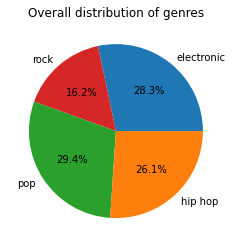

In [ ]:
# visualizes genres
counts = []
genres = []
for k, v in analyzer.weather_chi_squared(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type="temperature"))['col_total'].items():
    counts.append(v)
    genres.append(k)
plt.title("Overall distribution of genres")
plt.pie(counts, labels=genres, autopct="%1.1f%%", colors=[colors[key] for key in genres])
plt.show()

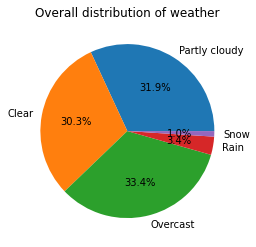

In [ ]:
# visualizes weather
counts = []
genres = []
for k, v in analyzer.weather_chi_squared(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type='weather'))['row_total'].items():
    counts.append(v)
    genres.append(k)
plt.title("Overall distribution of weather")
plt.pie(counts, labels=genres, autopct="%1.1f%%")
plt.show()

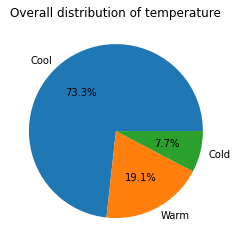

In [ ]:
# visualizes weather
counts = []
genres = []
for k, v in analyzer.weather_chi_squared(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type='temperature'))['row_total'].items():
    counts.append(v)
    genres.append(k)
plt.title("Overall distribution of temperature")
plt.pie(counts, labels=genres, autopct="%1.1f%%")
plt.show()

In [ ]:
def plotvar(dist_type, variation):
    counts = []
    genres = []
    for k, v in analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type=dist_type)[variation].items():
        counts.append(v)
        genres.append(k)
    plt.title("Overall distribution of genres across " + variation.lower() + " " + dist_type.lower())
    plt.pie(counts, labels=genres, autopct="%1.1f%%", colors=[colors[key] for key in genres])
    plt.show()

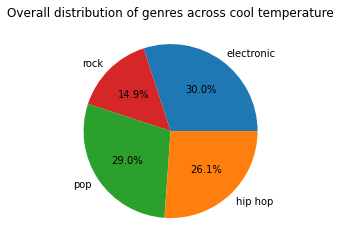

In [ ]:
# visualizes cool temp dist
plotvar("temperature", "Cool")

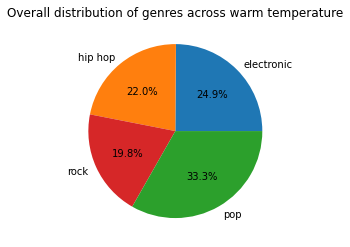

In [ ]:
# visualizes warm temp dist
plotvar("temperature", "Warm")

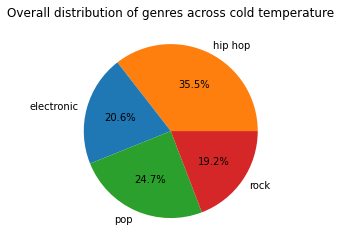

In [ ]:
# visualizes cold temp dist
plotvar("temperature", "Cold")

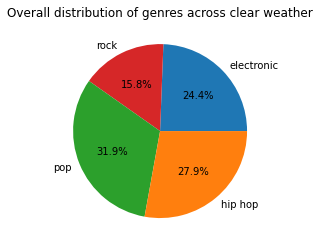

In [ ]:
# visualizes clear weather dist
plotvar("weather", "Clear")

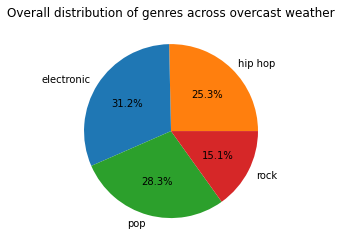

In [ ]:
# visualizes clear weather dist
plotvar("weather", "Overcast")

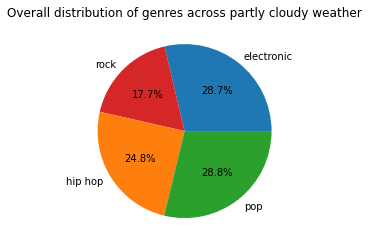

In [ ]:
# visualizes clear weather dist
plotvar("weather", "Partly cloudy")

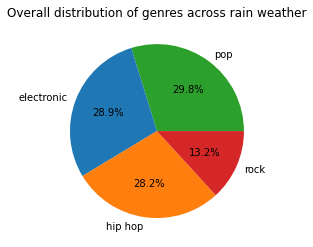

In [ ]:
# visualizes clear weather dist
plotvar("weather", "Rain")

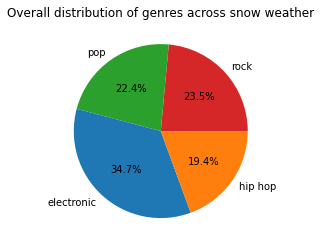

In [ ]:
# visualizes clear weather dist
plotvar("weather", "Snow")

### Chi-Squared Test
Run two chi-squared tests for homogeneity: one for the distribution of genre depending on the temperature (for this dataset 'warm' 'cool' and 'cold'), and another for the distribution of genre depending on the weather (for this dataset 'partly cloudy' 'clear' 'overcast' 'rain' and 'snow')

In [ ]:
# chi-squared values for each distribution
weather_distribution = analyzer.weather_chi_squared(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type="weather"))
temperature_distribution = analyzer.weather_chi_squared(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type="temperature"))
print("Chi squared for temperature", temperature_distribution['chi_squared'])
print("Chi squared for weather", weather_distribution['chi_squared'])
print("Cumulative p-val for temperature", weather_distribution['p_val'])
print("Cumulative p-val for weather", temperature_distribution['p_val'])

Chi squared for temperature 190.62469635947392
Chi squared for weather 98.14270381218185
Cumulative p-val for temperature 1.2857272252759642e-15
Cumulative p-val for weather 1.873932277940912e-38


In [ ]:
# original values for the temperature distribution
pd.DataFrame(temperature_distribution['original'])

,Cool,Warm,Cold
electronic,3715,801,267
rock,1846,638,249
pop,3583,1070,321
hip hop,3232,709,461


In [ ]:
# expected values for the temperature distribution
pd.DataFrame(temperature_distribution['expected'])

,Cool,Warm,Cold
electronic,3504.286526,911.182453,367.531021
rock,2002.344779,520.648473,210.006749
pop,3644.223538,947.568790,382.207672
hip hop,3225.145157,838.600284,338.254558


In [ ]:
# difference original-expected for the temperature distribution
pd.DataFrame(temperature_distribution['original']) - pd.DataFrame(temperature_distribution['expected'])

,Cool,Warm,Cold
electronic,210.713474,-110.182453,-100.531021
rock,-156.344779,117.351527,38.993251
pop,-61.223538,122.431210,-61.207672
hip hop,6.854843,-129.600284,122.745442


In [ ]:
# component matrix for the temperature distribution
pd.DataFrame(temperature_distribution['component'])

,Cool,Warm,Cold
electronic,12.670245,13.323537,27.498321
rock,12.207533,26.450440,7.240118
pop,1.028565,15.818800,9.801946
hip hop,0.014570,20.028891,44.541731


In [ ]:
# original values for the weather distribution
pd.DataFrame(weather_distribution['original'])

,Partly cloudy,Clear,Overcast,Rain,Snow
electronic,1520,1226,1731,162,59
rock,939,796,838,74,40
hip hop,1313,1400,1406,158,33
pop,1524,1604,1572,167,38


In [ ]:
# expected values for the weather distribution
pd.DataFrame(weather_distribution['expected'])

,Partly cloudy,Clear,Overcast,Rain,Snow
electronic,1498.831807,1422.418554,1569.867831,158.769759,48.112048
rock,857.250120,813.545904,897.878855,90.807651,27.517470
hip hop,1375.045783,1304.943373,1440.215060,145.657229,44.138554
pop,1564.872289,1485.092169,1639.038253,165.765361,50.231928


In [ ]:
# difference original-expected for the weather distribution
pd.DataFrame(weather_distribution['original']) - pd.DataFrame(weather_distribution['expected'])

,Partly cloudy,Clear,Overcast,Rain,Snow
electronic,21.168193,-196.418554,161.132169,3.230241,10.887952
rock,81.749880,-17.545904,-59.878855,-16.807651,12.482530
hip hop,-62.045783,95.056627,-34.215060,12.342771,-11.138554
pop,-40.872289,118.907831,-67.038253,1.234639,-12.231928


In [ ]:
# component matrix for the weather distribution
pd.DataFrame(weather_distribution['component'])

,Partly cloudy,Clear,Overcast,Rain,Snow
electronic,0.298961,27.122993,16.538702,0.065721,2.463988
rock,7.795908,0.378416,3.993275,3.110940,5.662350
pop,1.067527,9.520670,2.741930,0.009196,2.978585
hip hop,2.799673,6.924256,0.812844,1.045908,2.810862


In [ ]:
# relative frequencies for temperature distribution
x = pd.DataFrame(weather_distribution['expected'])
for k, v in x.items():
    for i in v:
        print(round(i/sum(v), 2))
    print()

0.28
0.16
0.3
0.26

0.28
0.16
0.3
0.26

0.28
0.16
0.3
0.26

0.28
0.16
0.3
0.26

0.28
0.16
0.3
0.26



We run into an issue when we try to do the same combining both distributions--we can't run a chi-squared test for homogeneity on these because not all expected counts are >= 5.

In [ ]:
dist = analyzer.weather_chi_squared(analyzer.weather_distributions_genres(analyzer.artist_genres(), dist_type="both"))

EXPECTED VALUE ERROR: CONDITIONS INVALID for Cold;Rain, pop, expected value 4.136746987951807, observed count 8
EXPECTED VALUE ERROR: CONDITIONS INVALID for Cold;Rain, rock, expected value 2.266144578313253, observed count 2
EXPECTED VALUE ERROR: CONDITIONS INVALID for Cold;Rain, hip hop, expected value 3.6349397590361447, observed count 3
EXPECTED VALUE ERROR: CONDITIONS INVALID for Cold;Rain, electronic, expected value 3.962168674698795, observed count 1


We can see based on the component and difference matrices that several trends emerge across both distributions.

Let's run a few tests to see how unusual these high components and differences are compared to each other. We'll compare different genres across the same weather.

### Two-proportion Z tests

In [ ]:
w = weather_distribution['original']
wr = weather_distribution['row_total']
t = temperature_distribution['original']
tr = temperature_distribution['row_total']

In [ ]:
def hypothesis_general_form(t1, t2, t3, comp="more"):
    return "Is it statistically unlikely that I do not listen to " + comp + " " + t1 + " music than " + t2 + " music on " + t3 + " days?"

def do_ztest(t1, t2, t3, dist, row, comp="more"):
    print(hypothesis_general_form(t1, t2, t3.lower(), comp=comp))
    return analyzer.two_samp_z_test(dist[t3][t1], row[t3], dist[t3][t2], row[t3])

In [ ]:
do_ztest("hip hop", "electronic", "Cold", t, tr)

Is it statistically unlikely that I do not listen to more hip hop music than electronic music on cold days?


{'SE': 0.01763303579278803,
 'p1': 0.3551617873651772,
 'p2': 0.20570107858243453,
 'p_val': 1.1635865049308985e-17,
 'phat_c': 0.28043143297380585,
 'z': 8.476175659092835}

In [ ]:
do_ztest("electronic", "rock", "Warm", t, tr)

Is it statistically unlikely that I do not listen to more electronic music than rock music on warm days?


{'SE': 0.01038702110893763,
 'p1': 0.24891236793039154,
 'p2': 0.19825978868862648,
 'p_val': 5.398521179368137e-07,
 'phat_c': 0.22358607830950902,
 'z': 4.87652607138542}

In [ ]:
do_ztest("electronic", "rock", "Cool", t, tr)

Is it statistically unlikely that I do not listen to more electronic music than rock music on cool days?


{'SE': 0.005305664709916518,
 'p1': 0.3001777634130575,
 'p2': 0.14915966386554622,
 'p_val': 1.655764001881384e-178,
 'phat_c': 0.22466871363930188,
 'z': 28.463558819548457}

In [ ]:
do_ztest("pop", "electronic", "Partly cloudy", w, wr)

Is it statistically unlikely that I do not listen to more pop music than electronic music on partly cloudy days?


{'SE': 0.00879430062146165,
 'p1': 0.2877643504531722,
 'p2': 0.28700906344410876,
 'p_val': 0.4657794376108297,
 'phat_c': 0.2873867069486405,
 'z': 0.08588369235641774}

In [ ]:
do_ztest("pop", "electronic", "Clear", w, wr)

Is it statistically unlikely that I do not listen to more pop music than electronic music on clear days?


{'SE': 0.008971668859695666,
 'p1': 0.31914046955829684,
 'p2': 0.2439315559092718,
 'p_val': 2.5812072946184144e-17,
 'phat_c': 0.2815360127337843,
 'z': 8.382934638492248}

In [ ]:
do_ztest("electronic", "pop", "Overcast", w, wr)

Is it statistically unlikely that I do not listen to more electronic music than pop music on overcast days?


{'SE': 0.008682576978032153,
 'p1': 0.3120605732828556,
 'p2': 0.2833964305029746,
 'p_val': 0.0004811201870327518,
 'phat_c': 0.2977285018929151,
 'z': 3.301340472120701}

In [ ]:
do_ztest("hip hop", "rock", "Rain", w, wr)

Is it statistically unlikely that I do not listen to more hip hop music than rock music on rain days?


{'SE': 0.024181303395830078,
 'p1': 0.2816399286987522,
 'p2': 0.1319073083778966,
 'p_val': 2.968727028676242e-10,
 'phat_c': 0.20677361853832443,
 'z': 6.1920822823254476}